In [1]:
import sys
sys.path.append("../")
sys.path.append("../../../assets")

# Get rid of annoying tf warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import bayesflow as beef
import pandas as pd

from experiments import NonStationaryDDMExperiment
from models import RandomWalkDDM, MixtureRandomWalkDDM, LevyFlightDDM, RegimeSwitchingDDM

/Users/lukas/opt/miniconda3/envs/beef/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# gpu setting and checking
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Constants

In [2]:
FIT_MODELS = True

NUM_OBS = 768
NUM_SAMPLES = 1000

MICRO_PARAM_LABELS = ['Drift rate', 'Threshold', 'Non-decision time']
MICRO_PARAM_NAMES  = [r'v', r'a', r'\tau']
MACRO_PARAM_LABELS = ['Transition std. deviation', 'Switch Probability']
MACRO_PARAM_NAMES  = [r'\sigma', r'q']
COMPARISON_COLOR = '#133a76'

FONT_SIZE_1 = 22
FONT_SIZE_2 = 20
FONT_SIZE_3 = 18

In [3]:
mixture_random_walk_model = MixtureRandomWalkDDM()
mixture_random_walk_experiment = NonStationaryDDMExperiment(
    mixture_random_walk_model,
    checkpoint_path="../checkpoints/smoothing_mixture_random_walk_ddm"
    )

# levy_flight_model = LevyFlightDDM()
# levy_flight_experiment = NonStationaryDDMExperiment(
#     levy_flight_model,
#     checkpoint_path="../checkpoints/levy_flight_ddm"
#     )

# regime_switching_model = RegimeSwitchingDDM()
# regime_switching_experiment = NonStationaryDDMExperiment(
#     regime_switching_model,
#     checkpoint_path="../checkpoints/regime_switching_ddm"
#     )

INFO:root:Performing 2 pilot runs with the mixture_random_walk_ddm model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 800, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 800)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 5)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 800, 3)
INFO:root:No shared_prior_draws provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.
INFO:root:Loaded loss history from ../checkpoints/smoothing_mixture_random_walk_ddm/history_75.pkl.
INFO:root:Networks loaded from ../checkpoints/smoothing_mixture_random_walk_ddm/ckpt-75
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


# Evaluation

## Calibration Error

## Parameter Recovery

In [14]:
val_data = mixture_random_walk_model.configure(mixture_random_walk_model.generate(1))
true_local_params = val_data['local_parameters'] * mixture_random_walk_model.local_prior_stds + mixture_random_walk_model.local_prior_means
true_hyper_params = val_data['hyper_parameters'] * mixture_random_walk_model.hyper_prior_std + mixture_random_walk_model.hyper_prior_mean

In [15]:
with tf.device('/cpu:0'):
    samples = mixture_random_walk_experiment.amortizer.sample(val_data, NUM_SAMPLES)

### Local Parameters

In [16]:
local_post_samples = samples['local_samples'] * mixture_random_walk_model.local_prior_stds + mixture_random_walk_model.local_prior_means
local_post_mean = np.mean(local_post_samples, axis=1)
local_post_quantiles = np.quantile(local_post_samples, [0.025, 0.975], axis=1)

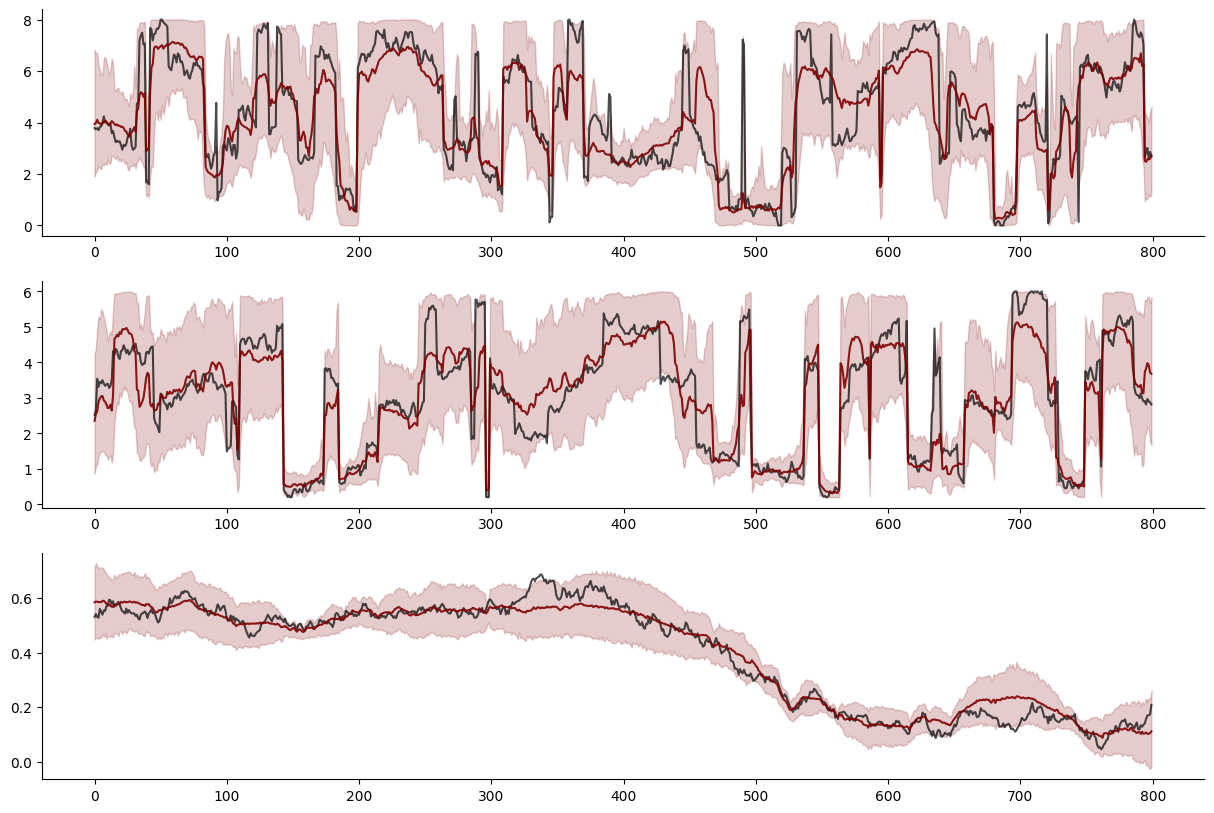

In [17]:
fig, axarr = plt.subplots(3, 1, figsize=(15, 10))
for i, ax in enumerate(axarr.flat):
    ax.plot(range(800), true_local_params[0, :, i] , color='black', alpha=0.7)
    ax.fill_between(range(800), local_post_quantiles[0, :, i], local_post_quantiles[1, :, i], color='maroon', alpha=0.2)
    ax.plot(range(800), local_post_mean[:, i], color='maroon', alpha=0.9)
sns.despine()

### Hyper Parameters

In [18]:
hyper_post_samples = samples['global_samples'] * mixture_random_walk_model.hyper_prior_std + mixture_random_walk_model.hyper_prior_mean
hyper_prior_draws = mixture_random_walk_model.prior(NUM_SAMPLES)['hyper_parameters']

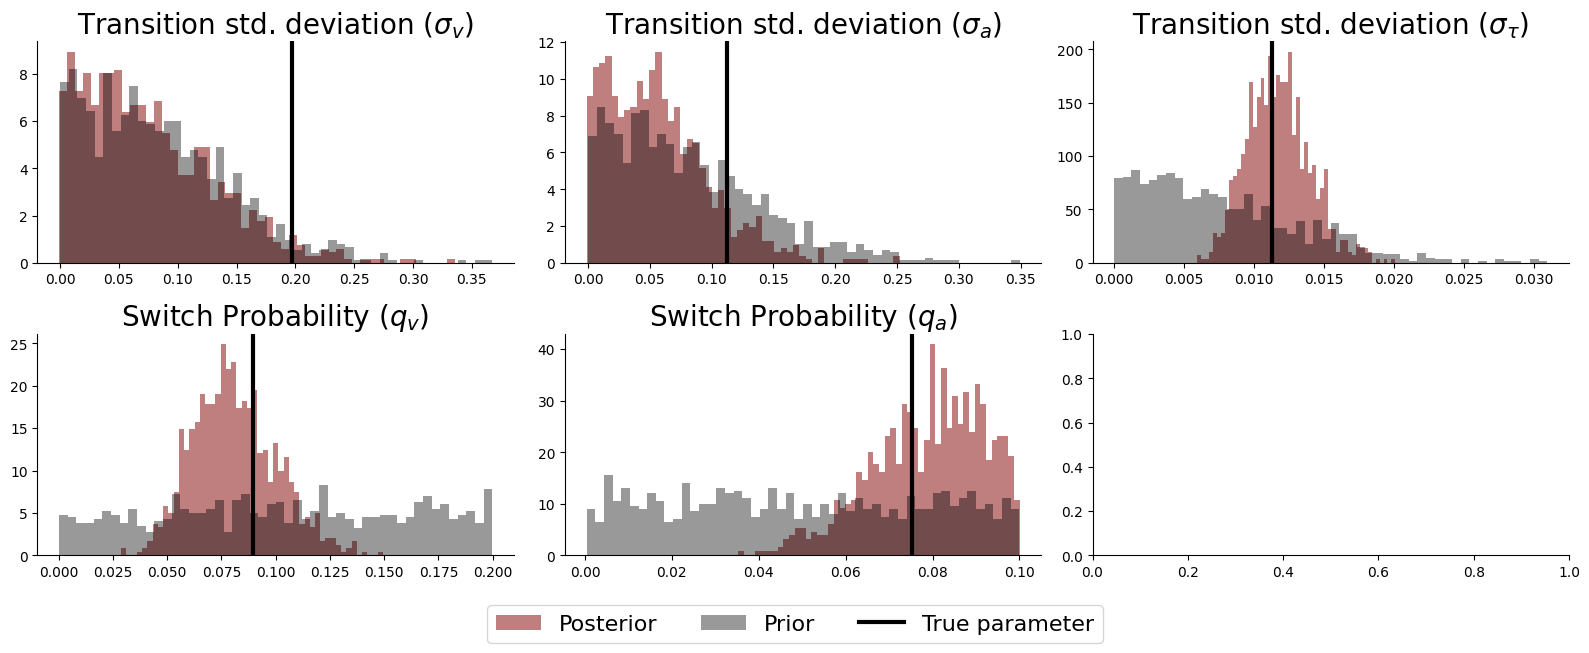

In [19]:
fig, axarr = plt.subplots(2, 3, figsize=(16, 6))
for i, ax in enumerate(axarr.flat):
    if i == 5:
        break
    ax.hist(hyper_post_samples[:, i], density=True, bins=50,
                 color='maroon', alpha=0.5, label='Posterior')
    ax.hist(hyper_prior_draws[:, i], density=True, bins=50,
                 color='black', alpha=0.4, label='Prior')
    ax.axvline(true_hyper_params[0, i], color='black',
               label='True parameter', lw=3)
    
    if i < 3:
        ax.set_title(f'{MACRO_PARAM_LABELS[0]} (${MACRO_PARAM_NAMES[0]}_{MICRO_PARAM_NAMES[i]}$)', fontsize=20)
    else:
        ax.set_title(f'{MACRO_PARAM_LABELS[1]} (${MACRO_PARAM_NAMES[1]}_{MICRO_PARAM_NAMES[i-3]}$)', fontsize=20)

    if i == 0:
        fig.legend(fontsize=16, loc='center',
                 bbox_to_anchor=(0.5, -0.05), ncol=4)

fig.tight_layout()
sns.despine()

# Parameter Estimation

In [22]:
data = pd.read_csv('../data/data_color_discrimination.csv')
data['rt'] = np.where(data['correct'] == 0, -data['rt'], data['rt'])

In [23]:
NUM_SUBJECTS = len(np.unique(data['id']))
emp_data = np.zeros((NUM_SUBJECTS, NUM_OBS, 1), dtype=np.float32)
for i in range(NUM_SUBJECTS):
    tmp = data[data['id'] == i+1]
    emp_data[i] = tmp['rt'].to_numpy()[:, np.newaxis]

emp_data.shape

(14, 768, 1)

In [24]:
%%time
mrw_local_post_samples = np.zeros((NUM_SUBJECTS, NUM_OBS, NUM_SAMPLES, 3))
mrw_hyper_post_samples = np.zeros((NUM_SUBJECTS, NUM_SAMPLES, 5))
lf_local_post_samples = np.zeros((NUM_SUBJECTS, NUM_OBS, NUM_SAMPLES, 3))
lf_hyper_post_samples = np.zeros((NUM_SUBJECTS, NUM_SAMPLES, 5))
rs_local_post_samples = np.zeros((NUM_SUBJECTS, NUM_OBS, NUM_SAMPLES, 3))
rs_hyper_post_samples = np.zeros((NUM_SUBJECTS, NUM_SAMPLES, 5))
with tf.device('/cpu:0'):
    for i in range(NUM_SUBJECTS):
        tmp_data = {'summary_conditions': emp_data[i:i+1]}
        samples = mixture_random_walk_experiment.amortizer.sample(tmp_data, NUM_SAMPLES)
        local_post_samples[i] = samples['local_samples']
        hyper_post_samples[i] = samples['global_samples']

CPU times: user 18min 9s, sys: 5min 21s, total: 23min 31s
Wall time: 4min 32s


In [25]:
local_post = local_post_samples * mixture_random_walk_model.local_prior_stds + mixture_random_walk_model.local_prior_means
hyper_post = hyper_post_samples * mixture_random_walk_model.hyper_prior_std + mixture_random_walk_model.hyper_prior_mean

In [57]:
np.save("../data/local_post_samples_mrw.npy", local_post)

In [26]:
# get person data
which = 3
person_data = data[data['id'] == which + 1]
condition = person_data['speed_condition'].to_numpy()
idx_speed = np.where(condition[:-1] != condition[1:])[0]
idx_speed = np.append(idx_speed, NUM_OBS)
idx_speed

array([ 47,  95, 143, 191, 239, 287, 335, 383, 431, 479, 527, 575, 623,
       671, 719, 768])

In [27]:
person_post_samples = local_post[which]
post_mean = np.mean(person_post_samples, axis=1)
post_std = np.std(person_post_samples, axis=1)

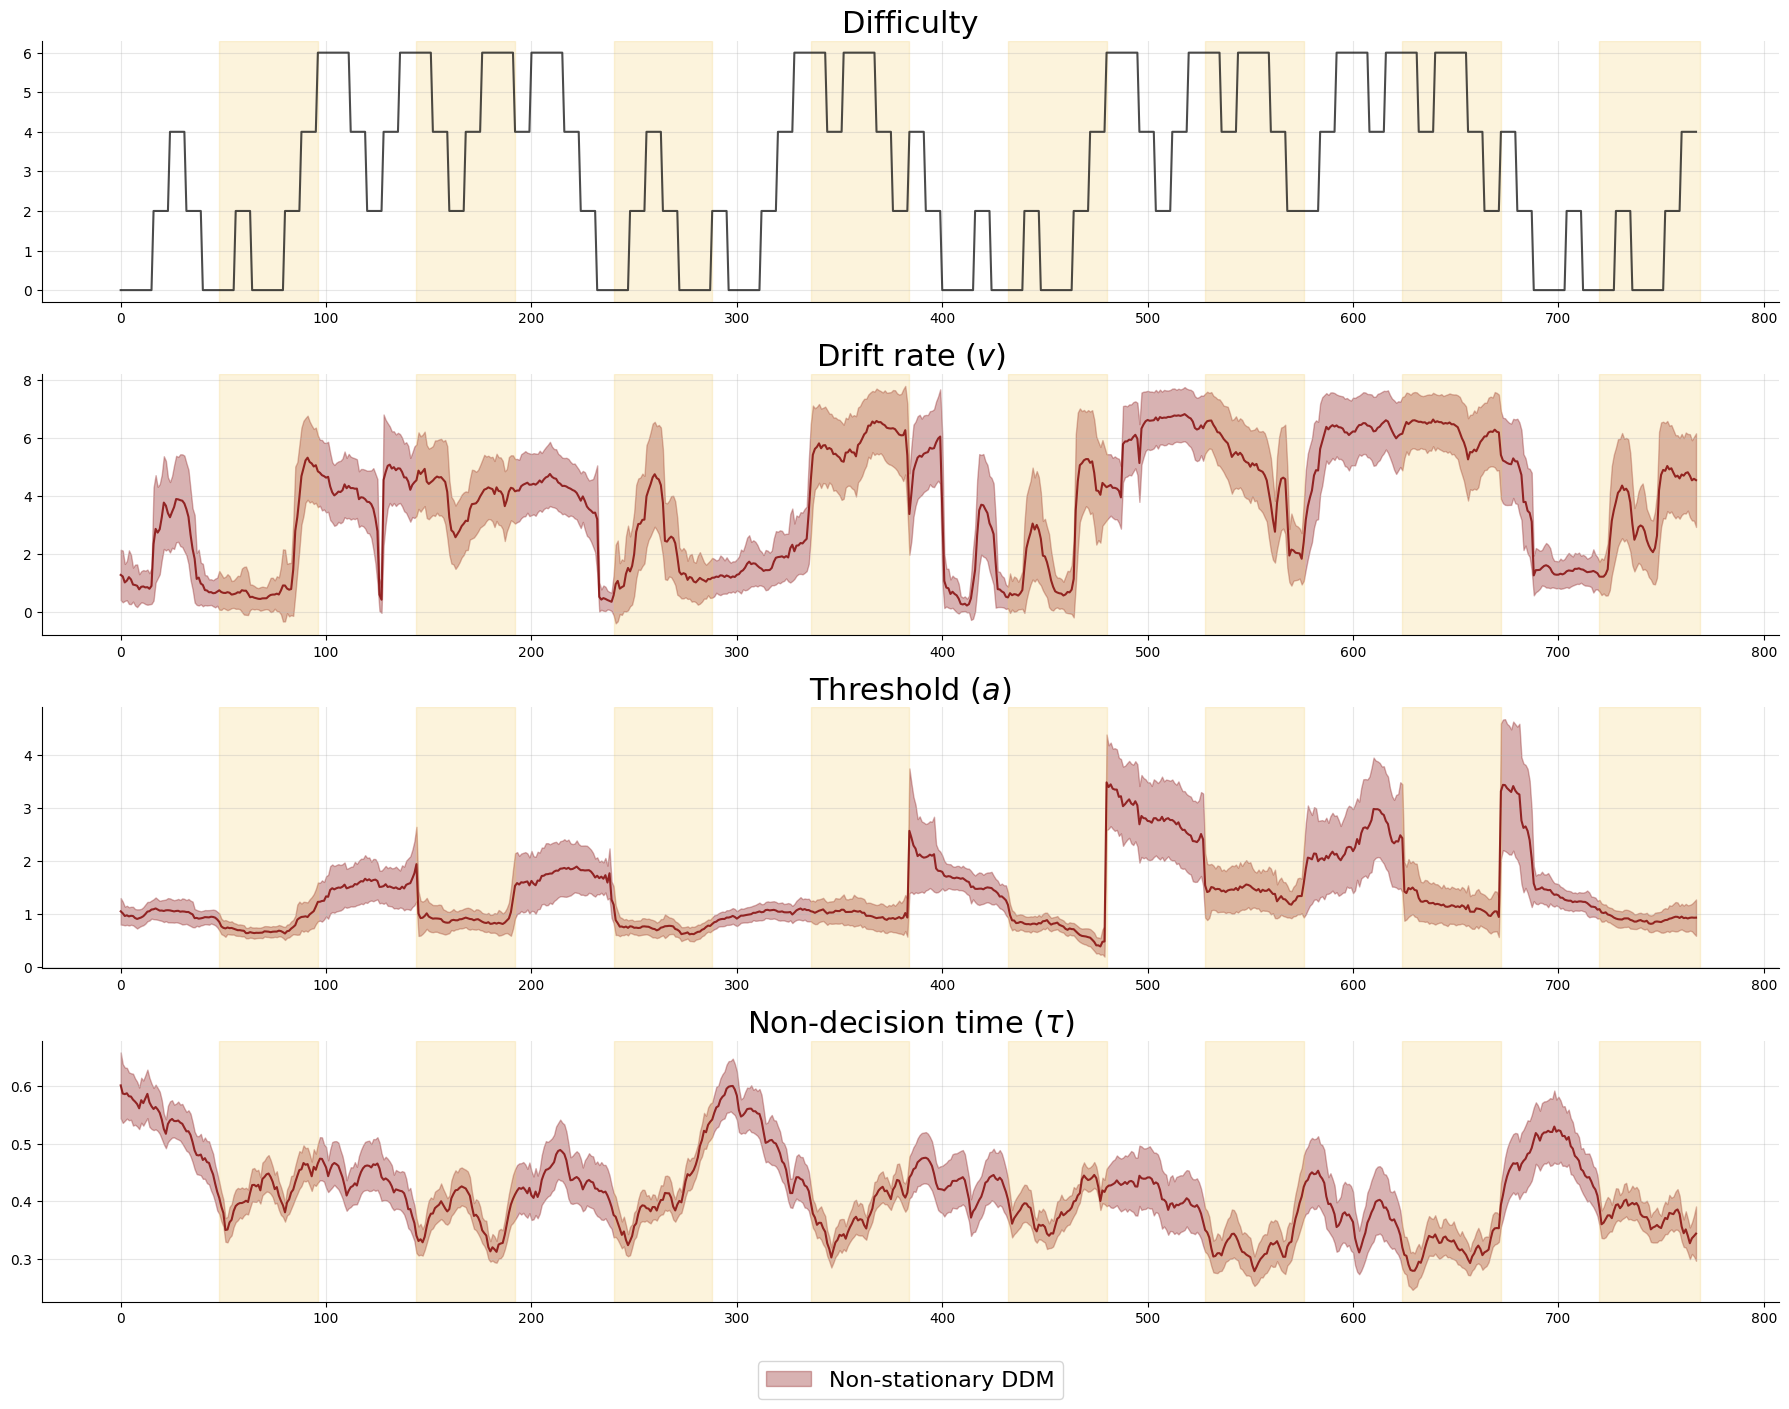

In [31]:
fig, axarr = plt.subplots(4, 1, figsize=(18, 14))
for i, ax in enumerate(axarr.flat):
    if i == 0:
        # ax.plot(range(N_OBS), person_data['difficulty'], color='black')
        ax.plot(range(NUM_OBS), (person_data['difficulty'] - 3) * -2, color='black', alpha=0.7)
        ax.set_title('Difficulty', fontsize=FONT_SIZE_1)
    else:
        # neural
        ax.fill_between(range(NUM_OBS), post_mean[:, i-1] - post_std[:, i-1],
                        post_mean[:, i-1] + post_std[:, i-1],
                        color='maroon', alpha=0.3, label="Non-stationary DDM")
        ax.plot(range(NUM_OBS), post_mean[:, i-1], color='maroon', alpha=0.8)
        ax.set_title(f'{MICRO_PARAM_LABELS[i-1]} (${MICRO_PARAM_NAMES[i-1]}$)', fontsize=FONT_SIZE_1)

        # stan
        # ax.fill_between(range(NUM_OBS), stan_post_means[:, i-1] - stan_post_stds[:, i-1],
        #                 stan_post_means[:, i-1] + stan_post_stds[:, i-1],
        #                 color=COMPARISON_COLOR, alpha=0.3, label="Stationary DDM")
        # ax.plot(range(N_OBS), stan_post_means[:, i-1], color=COMPARISON_COLOR, alpha=0.8)
    
    x = 0
    while x < idx_speed.shape[0]:
        ax.axvspan(idx_speed[x] + 1, idx_speed[x + 1] + 1, alpha=0.2, color='#f0c654')
        x = x + 2
    
    ax.grid(alpha=0.3)

# axarr[1].plot(range(N_OBS), (person_data['difficulty'] - 3) * -2, color='black', alpha=0.5)
    
    if i == 3:
        plt.subplots_adjust(hspace=0.5)
        plt.legend(fontsize=16, loc='center', 
                bbox_to_anchor=(0.5, -0.3), ncol=2)
sns.despine()
fig.tight_layout()
# plt.savefig("../plots/param_dynamics.png", dpi=300, bbox_inches="tight")

# Trajectory illustration

In [6]:
rw_model = RandomWalkDDM()
mrw_model = MixtureRandomWalkDDM()
levy_model = LevyFlightDDM()
rs_model = RegimeSwitchingDDM()
models = [rw_model, mrw_model, levy_model, rs_model]

INFO:root:Performing 2 pilot runs with the random_walk_ddm model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 800, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 800)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 800, 3)
INFO:root:No shared_prior_draws provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.
INFO:root:Performing 2 pilot runs with the mixture_random_walk_ddm model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 800, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 800)
INFO:root:Shape of hyper_prior_draws batch 

In [51]:
NUM_SIM = 1
sim_data = []
for model in models:
    sim_data.append(model.generate(NUM_SIM))

In [6]:
LABELS = [
    'Random walk', 'Mixture random walk',
    'Levy flight', 'Regime switching'
    ]
COLORS = [
    "orange", "maroon", "#133a76", "green"
]
FONT_SIZE_0 = 26
FONT_SIZE_1 = 28
FONT_SIZE_2 = 24
FONT_SIZE_3 = 20

NUM_STEPS = 800

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "sans-serif"

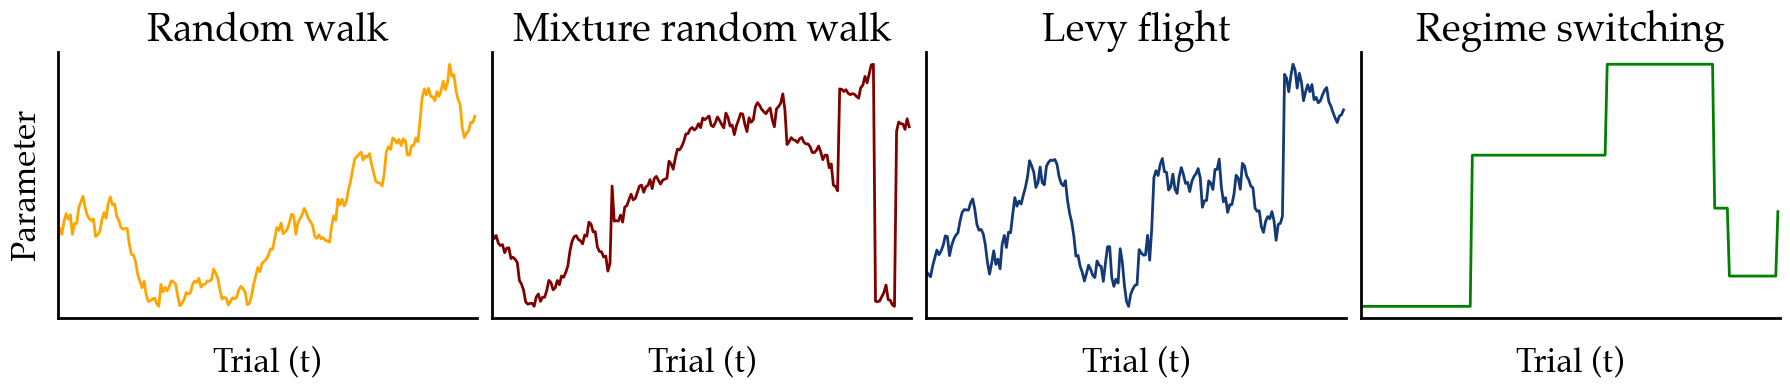

In [53]:
NUM_STEPS = 200
fig, axarr = plt.subplots(1, 4, figsize=(18, 4))
for i, ax in enumerate(axarr.flat):
    for j in range(NUM_SIM):
        ax.plot(range(NUM_STEPS), sim_data[i]['local_prior_draws'][j, :NUM_STEPS, 1], color=COLORS[i], lw=2, alpha=1)
    ax.set_title(LABELS[i], fontsize=FONT_SIZE_1)
    
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    ax.set_xlabel("Trial (t)", labelpad=20, fontsize=FONT_SIZE_2)
    if i == 0:
        ax.set_ylabel("Parameter", labelpad=10, fontsize=FONT_SIZE_2)

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(alpha=0.4)
    ax.set_xlim(1, NUM_STEPS)

    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2) 

    
sns.despine()
fig.tight_layout()
fig.savefig("../plots/exemplar_parameter_trajectories.pdf", dpi=300, bbox_inches="tight")

In [3]:
levy_model = LevyFlightDDM()

INFO:root:Performing 2 pilot runs with the levy_flight_ddm model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 800, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 800)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 5)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 800, 3)
INFO:root:No shared_prior_draws provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.


In [77]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "sans-serif"
from scipy.stats import halfnorm
NUM_STEPS = 200
COLORS = [
    "orange", "maroon", "#133a76", "green"
]
time = np.arange(NUM_STEPS)
noise = np.random.normal(0, 1, NUM_STEPS)
stat_var = 4 + 0.2 * noise
binning = np.concatenate(
    [np.repeat(5.0, NUM_STEPS/4), np.repeat(4.0, NUM_STEPS/4),
     np.repeat(3.0, NUM_STEPS/4), np.repeat(2.0, NUM_STEPS/4)]
)
regression = 5.0 - 0.015 * time
# frontend = np.concatenate([np.repeat(x, 10) for x in np.random.uniform(2, 5, 20)])
x_values = np.linspace(0, 2, 200)
scale_parameter = 0.25
x_values_2 = np.linspace(0, 0.3, 75)
frontend = halfnorm.pdf(x_values, scale=scale_parameter)
frontend[125:] = frontend[125:] + (np.exp(x_values_2) - 1) * 5
frontend = frontend + 1
superstats = levy_model.generate(1)['local_prior_draws'][0, :, 1]
params = [stat_var, binning, regression, frontend, superstats[:NUM_STEPS]]

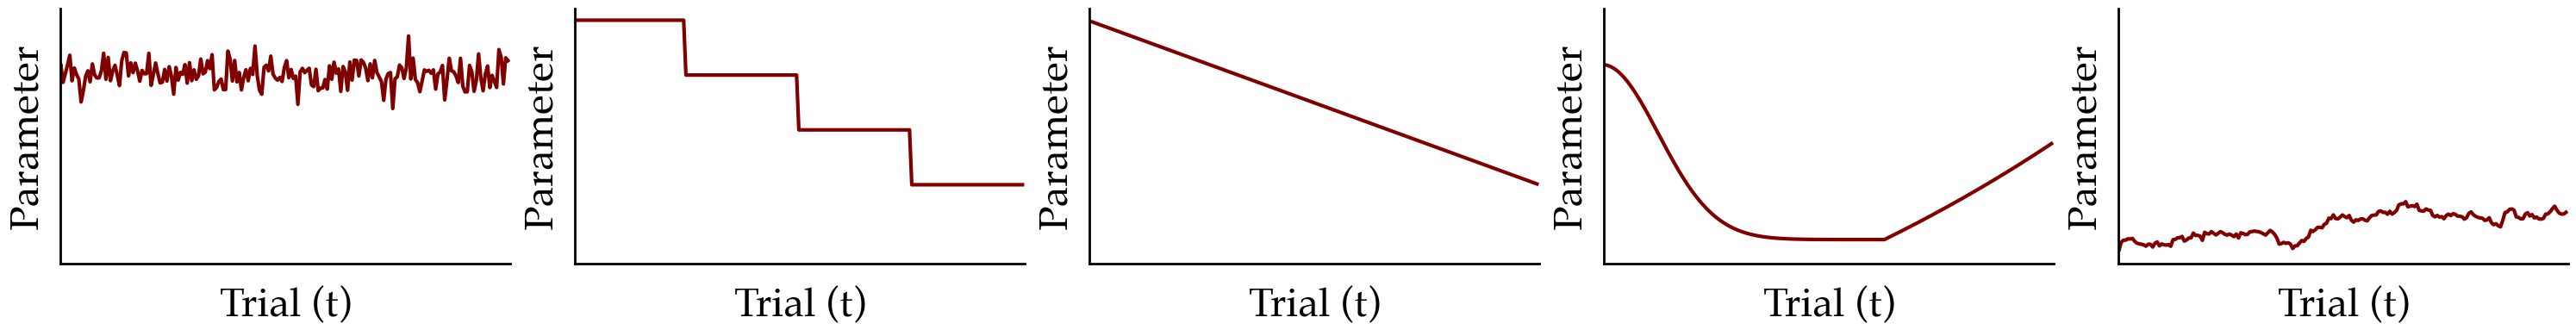

In [78]:
fig, axarr = plt.subplots(1, 5, figsize=(30, 4), sharey=True)
for i, ax in enumerate(axarr.flat):
    ax.plot(time, params[i], color=COLORS[1], lw=3, alpha=1)
    
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    ax.set_xlabel("Trial (t)", labelpad=20, fontsize=34)
    ax.set_ylabel("Parameter", labelpad=10, fontsize=34)

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(1, NUM_STEPS)

    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2) 

    
sns.despine()
fig.tight_layout()
fig.savefig("../plots/parameter_trajectories_illustration.pdf", dpi=300, bbox_inches="tight")

In [57]:
(np.exp(x_values_2) - 1) * 5

array([0.        , 0.02031141, 0.04070534, 0.06118211, 0.08174206,
       0.10238554, 0.12311287, 0.1439244 , 0.16482048, 0.18580144,
       0.20686763, 0.2280194 , 0.2492571 , 0.27058106, 0.29199165,
       0.31348922, 0.33507412, 0.3567467 , 0.37850732, 0.40035634,
       0.42229411, 0.444321  , 0.46643737, 0.48864359, 0.51094001,
       0.53332701, 0.55580495, 0.5783742 , 0.60103513, 0.62378812,
       0.64663354, 0.66957176, 0.69260317, 0.71572813, 0.73894704,
       0.76226026, 0.78566819, 0.80917121, 0.83276971, 0.85646407,
       0.88025468, 0.90414194, 0.92812624, 0.95220796, 0.97638751,
       1.00066529, 1.02504169, 1.04951711, 1.07409196, 1.09876664,
       1.12354156, 1.14841712, 1.17339373, 1.1984718 , 1.22365174,
       1.24893398, 1.27431891, 1.29980697, 1.32539857, 1.35109413,
       1.37689407, 1.40279882, 1.4288088 , 1.45492444, 1.48114616,
       1.50747441, 1.53390961, 1.5604522 , 1.58710262, 1.61386129,
       1.64072867, 1.66770518, 1.69479129, 1.72198742, 1.74929